In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [4]:
from brian2 import *
from brian2tools import *

import scipy

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc


In [8]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

#cx_spiking.inputs.save_route(route_file, h, v, save_route=False)

Generating route of length 1500 and vary_speed=True


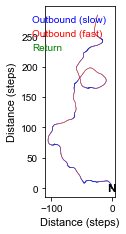

In [9]:
plotter.plot_route(h, v, T_outbound, 0, plot_speed=True)
plt.show()

In [28]:
def normalise_range(data, vmin=5, vmax=100):
    d = np.where(data >= 0, data, 0)
    d = ((d - d.min()) * (vmax - vmin)) / (d.max() - d.min()) + vmin
    return d

def compute_cos_headings(h, N=8, sigma=0.8, vmin=5, vmax=100):
    r'''
    Convert headings from Stone's simulator to spike rates
    that can be fed into a brian2 PoissonGroup

    Parameters
    ----------
    h: headings
        headings generated from Stone's simulator
    N: number of directions
        8 representing the cardinal directions (N, NE, E, SE, S, SW, W, NW)
    sigma: standard deviation 
        of a Gaussian distribution
    vmin: hertz
        minimum value for rescaling the rates
    vmax: hertz
        maximum value for rescaling the rates

    Returns
    -------
    headings: numpy array(n_steps * n_neurons)
        each row represents the rate for the neurons
    '''
    T_outbound = h.shape[0]
    headings = np.zeros((T_outbound, N))

    # Fixed locations of angles
    tl2_prefs = np.tile(np.linspace(0, 2*np.pi, N//2, endpoint=False), 2)

    for step in range(T_outbound):
        samples = np.cos(h[step] - tl2_prefs) + 1 # bring into [0,1]
        headings[step,:] = samples#np.roll(samples[:N], -int(np.ceil(N/2)))

    # Normalize between 5-100 Hz, the headings represent rate
    if vmin >= 0 and vmax > 0 and vmax > vmin:
        headings = normalise_range(headings, vmin=vmin, vmax=vmax)

    return headings

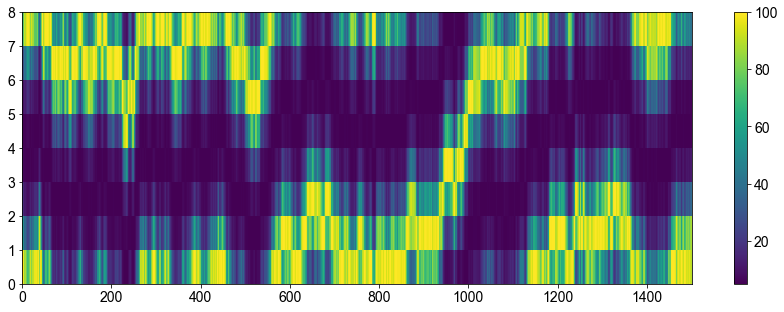

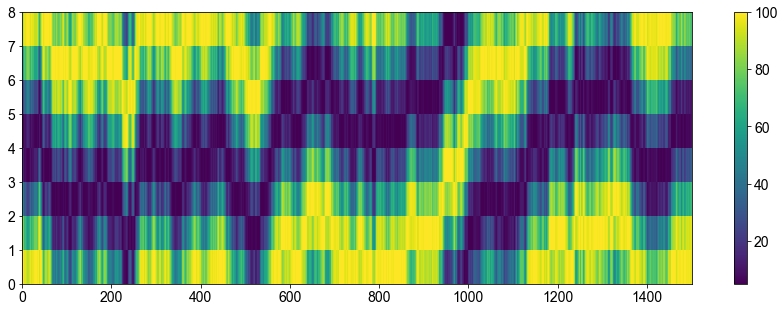

In [29]:
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings_cos = compute_cos_headings(h, N=N_TL2, vmin=5, vmax=100)

plt.figure(figsize=(15,5))
plt.pcolormesh(headings.T)
plt.colorbar()
plt.show()
plt.figure(figsize=(15,5))
plt.pcolormesh(headings_cos[:,:8].T)
plt.colorbar()
plt.show()

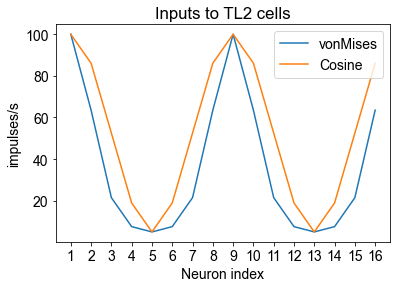

In [65]:
step = 0
sample = np.cos(h[step] - np.tile(np.linspace(0, 2*np.pi, 8, endpoint=False), 2))

tmp = cx_rate.noisy_sigmoid(sample, 6.8, 3.0, 0)

cosine = compute_cos_headings(np.array([h[step]]), N_TL2,vmin=5, vmax=100)
vonmises = cx_spiking.inputs.compute_headings(np.array([h[step]]), N=8, sigma=0.8, vmin=5, vmax=100)
vonmises = np.tile(vonmises,2)

#plt.plot(sample, label='original')
#plt.plot(tmp, label='sigmoid')
plt.plot(vonmises.T, label='von Mises')
plt.plot(cosine.T, label='Cosine')
plt.legend()
plt.xticks(np.arange(0, N_TL2), np.arange(1, N_TL2+1))
plt.xlabel('Neuron index')
plt.ylabel('impulses/s')
plt.title('Inputs to TL2 cells')
plt.show()

# OLD STUFF

In [6]:
def normalise_range(data, vmin=5, vmax=100):
    d = np.where(data >= 0, data, 0)
    d = ((d - d.min()) * (vmax - vmin)) / (d.max() - d.min()) + vmin
    return d
    

def compute_headings(h, N=8, loc=0, scale=0.8, vmin=5, vmax=100):
    T_outbound = h.shape[0]

    rv = scipy.stats.norm(loc=loc, scale=scale)
    x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), N, endpoint=True)
    pdf = rv.pdf(x)

    # Split the [-pi,pi] interval into bins
    bins = np.linspace(-np.pi, np.pi, N+1)

    # -1 required since the returned bins are 1-indexed
    digitized = np.digitize(h, bins) - 1
    
    headings = np.zeros((len(h), N))

    for t in range(T_outbound):
        # Shift angle
        # angle_shift = N//2 + digitized[t]
        angle_shift = digitized[t]
        headings[t,:] = np.roll(pdf, angle_shift)
    
    # Normalize between 5-100 Hz, the headings represents rate
    if vmin >= 0 and vmax > 0 and vmax > vmin:
        headings = normalise_range(headings, vmin=vmin, vmax=vmax)
    
    return headings, digitized

In [7]:
headings = compute_headings(h, N=N_TL2//2, loc=0, scale=0.8, vmin=5, vmax=100)

-3.1192654633327033 3.1342053592648513


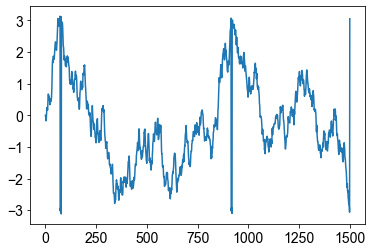

In [10]:
print(h.min(), h.max())
plt.plot(h)

-0.07138838839259698

-3.141592653589793 0.00022342753598986645
-2.356194490192345 0.0065190704745311
-1.5707963267948966 0.07255197397985688
-0.7853981633974483 0.3079834413552443
0.0 0.49867785050179086
0.7853981633974483 0.3079834413552443
1.5707963267948966 0.07255197397985688
2.356194490192345 0.0065190704745311
3.141592653589793 0.00022342753598986645
-3.141592653589793 0.00022342753598986645
-2.243994752564138 0.009756816762980803
-1.3463968515384828 0.12099175716341033
-0.4487989505128276 0.4260686711001494
0.4487989505128276 0.4260686711001494
1.3463968515384828 0.12099175716341033
2.243994752564138 0.009756816762980803
3.141592653589793 0.00022342753598986645


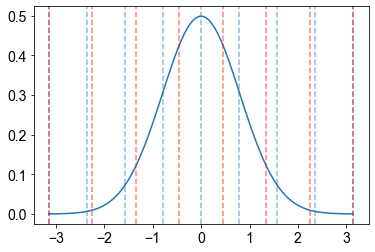

0.4966963189912904


In [38]:
print(h[2])
print()
mu = 0
sigma = 0.8
rv = scipy.stats.norm(loc=mu, scale=sigma)
x = np.linspace(mu - np.pi, mu + np.pi, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma))
for i in np.linspace(mu-np.pi, mu+np.pi, 8+1):
    print(i, rv.pdf(i))
    plt.axvline(i, ls='--', alpha=0.5)
for i in np.linspace(mu-np.pi, mu+np.pi, 8, endpoint=True):
    print(i, rv.pdf(i))
    plt.axvline(i, color='r', ls='--', alpha=0.5)


plt.show()

print(rv.pdf(h[2]))

1.570932206185776
10


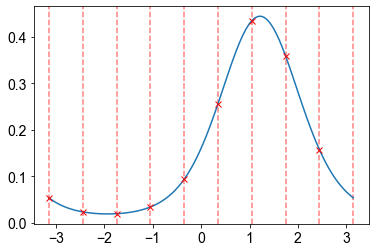

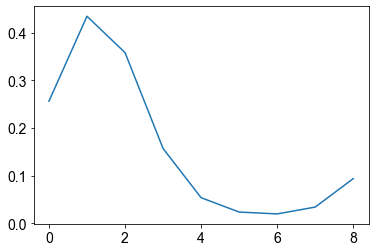

69.60639080292516 1.2148602655504446


In [72]:
mu2 = np.pi/4
kappa = 1. / sigma**2
rv2 = scipy.stats.vonmises(mu, kappa)
x = np.linspace(mu - np.pi, mu + np.pi, 100)
#plt.plot(x, scipy.stats.vonmises.pdf(x, kappa, loc=mu2))

for i in np.linspace(0-np.pi, 0+np.pi, 9+1, endpoint=True):
    #print(i, rv.pdf(i))
    plt.axvline(i, color='r', ls='--', alpha=0.5)

#for i in np.arange(0-np.pi+np.pi/8, 0+np.pi, np.pi/4, ):
    #print(i, rv.pdf(i))
    #plt.axvline(i, color='k', ls='--', alpha=0.5)

N = 9
xs = np.linspace(0-np.pi, 0+np.pi, N+1, endpoint=True)
print(h[100])
samples = scipy.stats.vonmises.pdf(xs, kappa, loc=h[150])
print(len(xs))
plt.plot(x, scipy.stats.vonmises.pdf(x, kappa, loc=h[150]))
plt.plot(xs[:N], samples[:N], 'rx')
plt.show()

values = np.roll(samples[:N], -int(np.ceil(N/2)))
plt.plot(values[:N])
plt.show()

print(57.2958 * h[150], h[150])

In [17]:
headings = cx_spiking.inputs.compute_headings(h, N=8, sigma=0.8, vmin=5, vmax=100)
headings = np.tile(headings, 2)

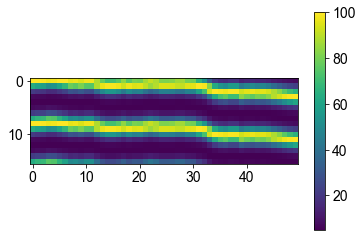

In [18]:
plt.imshow(headings.T[:,:50])
plt.colorbar()
plt.show()

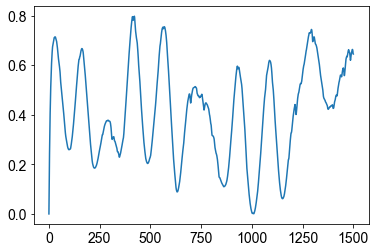

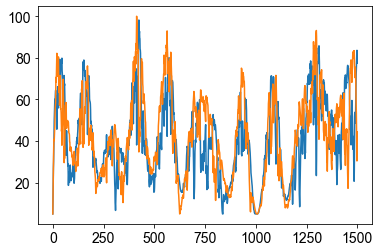

In [8]:
# Obtain speed 
def get_speed(v, T_outbound):
    xy = np.vstack([np.array([0.0, 0.0]), np.cumsum(v, axis=0)])
    x, y = xy[:, 0], xy[:, 1]

    speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]),
                    axis=0), 0, 1)

    return speed

speed = get_speed(v, T_outbound)    
plt.plot(speed)
plt.show()


def get_flow(heading, velocity, vmin=5, vmax=100, preferred_angle=np.pi/4):
    '''
    Calculate optic flow depending on preference angles. [L, R]
    Preferred angle is 45 degrees
    From central_complex.py, line 45
    '''
    flow = np.zeros((velocity.shape[0], 2))
    for i in range(v.shape[0]):
        A = np.array([[np.sin(heading[i] + preferred_angle),
                       np.cos(heading[i] + preferred_angle)],
                      [np.sin(heading[i] - preferred_angle),
                       np.cos(heading[i] - preferred_angle)]])
        flow[i,:] = np.dot(A, velocity[i,:])
    flow = np.clip(flow, 0, 1)
    
    if vmin > 0 and vmin > 0 and vmax > vmin:
        flow = normalise_range(flow, vmin=vmin, vmax=vmax)

    return flow


flow = get_flow(h,v, vmin=5, vmax=100)
plt.plot(flow)
plt.show()

In [4]:
start_scope()
time_step = 20
flow_scaled = flow * 100 # from [0,1] to [0,100] Hz
stimulus = TimedArray(flow_scaled*Hz, dt=1.*time_step*ms)
P = PoissonGroup(2, rates='stimulus(t,i)')
spike_monitor = SpikeMonitor(P)

In [5]:
run(T_outbound*time_step*ms)

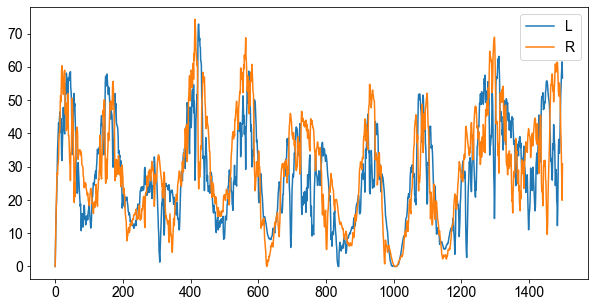

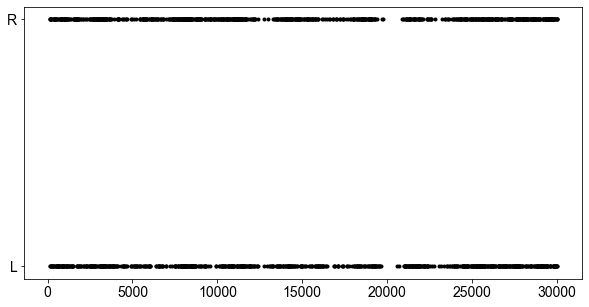

In [6]:
figure(figsize=(10,5))
plt.plot(flow_scaled[:,0], label='L')
plt.plot(flow_scaled[:,1], label='R')
plt.legend()
plt.show()


figure(figsize=(10,5))
plot(spike_monitor.t/ms, spike_monitor.i, '.k', markersize=6)
yticks([0,1],['L','R'])
show()

In [91]:
#plt.plot(v)
#plt.show()
#v_diff = np.diff(v, axis=0)
#print(v_diff.shape)

#plt.plot(v_diff[:,0], label='L')
#plt.plot(v_diff[:,1], label='R')
#plt.show()

#baseline = 50
#v_new = baseline + baseline * v_diff * 8
#plt.plot(v_new[:,0], label='L')
#plt.plot(v_new[:,1], label='R')
#plt.show()

In [92]:
#print(v.shape)

#plt.plot(v[:,0], label='L')
#plt.plot(v[:,1], label='R')
#plt.legend()
#plt.show()

#v_scaled = normalise_range(v, vmin=5, vmax=100)
#plt.plot(v_scaled[:,0], label='L')
#plt.plot(v_scaled[:,1], label='R')
#plt.legend()
#plt.show()

#plotter.plot_route(h, v, T_outbound, 0, plot_speed=True)

In [41]:
start_scope()
time_step = 10
stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P = PoissonGroup(16, rates='stimulus(t,i)')
spike_monitor = SpikeMonitor(P)

In [7]:
run(T_outbound*time_step*ms)

In [88]:
start_scope()

# Constants
N_TL2 = 16

# Neuron specification
El = -52 * mV # resting potential (mV)
Vt = -45 * mV # spike threshold (mV)
Vr = El       # reset potential (mV)

Cm = 0.002 * ufarad # membrane capacitance (uF)
Rm = 10 * Mohm      # membrane resistance (MOhm)
taum = Cm * Rm      # = 20ms membrane time constant (ms) 

#ge = 0 * mV # excitatory synaptic conductance ()
#gi = 0 * mV # inhibitory synaptic conductance ()
taue = 5 * ms # excitatory synaptic time constant (ms)
taui = 10 * ms # inhibitory synaptic time constant (ms)


eqs = '''
      dVm/dt  = ((El - Vm) + I_syn) / taum : volt
      I_syn = ge + gi : volt
      dge/dt = -ge/taue : volt
      dgi/dt = -gi/taui : volt
      '''
threshold_eqs = 'Vm >= Vt'
reset_eqs = 'Vm = Vr'

G_TL2 = NeuronGroup(N=N_TL2, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
G_TL2.Vm = Vr
G_TL2.ge = 0 * mV
G_TL2.gi = 0 * mV

In [89]:
def add_monitors(NG, variables_to_record=['Vm', 'ge', 'gi']):
    state_monitor = StateMonitor(NG, variables_to_record, record=True)
    spike_monitor = SpikeMonitor(NG)
    return state_monitor, spike_monitor

STM_TL2, SPM_TL2 = add_monitors(G_TL2)

In [90]:
we = (60 * 0.27 / 10) * mV
wi = (20 * 4.5 / 10) * mV

synapses_model = '''w : 1'''
synapses_eqs_ex = '''ge += we * w'''
synapses_eqs_in = '''gi += wi * w'''

In [91]:
#stimulus = TimedArray(np.tile([100., 0.], 2)*Hz, dt=100.*ms)
stimulus = TimedArray(100*h*Hz, dt=1500.*ms)

P = PoissonGroup(N_TL2, rates='stimulus(t)')
S = Synapses(P, G_TL2, model=synapses_model, on_pre=synapses_eqs_in)
S.connect(j='i')
S.w = 1

In [92]:
run(1500*ms)

In [52]:
len(spike_monitor.t/ms)

3944

In [1]:
figure(figsize=(10,5))
bins = numpy.linspace(-np.pi, np.pi, 8+1)
plt.plot(h)
for b in bins:
    plt.axhline(b, ls='dashed', color='r', alpha=0.5)
ylabel('angle[-pi, pi]')
xlabel('steps')
#plt.savefig('path.pdf')
plt.show()

figure(figsize=(10,5))
plot(spike_monitor.t/ms, spike_monitor.i, '.k', markersize=6)
plot(np.array(range(0, T_outbound*time_step, time_step)), np.argmax(headings,axis=1),'xr', markersize=3,   alpha=0.2)
plot(np.array(range(0, T_outbound*time_step, time_step)), 8+np.argmax(headings,axis=1),'xr', markersize=3,   alpha=0.2)
ylabel('neuron index')
xlabel('ms')
#plt.savefig('spikes.pdf')
plt.show()

NameError: name 'figure' is not defined